In [3]:
import pandas as pd
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("../data/contest_results.csv", parse_dates=["contest_date"])
df = df[
    [
        "contest_date",
        "contest_name",
        "organization",
        "division",
        "class",
        "competitor_name",
    ]
]
df_elo = pd.read_csv("../data/contest_results_elo.csv", parse_dates=["contest_date"])
df.loc[df["division"] == "women's wellness", "division"] = "wellness"

In [15]:
df_pro_card = df[df["class"].str.contains("pro card")][["division", "competitor_name"]]

In [16]:
# find the elo rating for the competitor when they did their first pro show
df_temp = df_elo[(df_elo["organization"] == "ifbb") & (df_elo["class"] == "open")]
df_ifbb_open = pd.merge(
    df_temp, df_pro_card, how="inner", on=["division", "competitor_name"]
)
df_ifbb_open.head()

,Unnamed: 0,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
0,17219,ifbb,ifbb pro grand prix,2012-04-14,women's physique,open,donna jones,13.0,1500.000000,5.0
1,17656,ifbb,ifbb emerald cup,2012-04-21,women's bodybuilding,open,tarna alderman,2.0,1500.000000,2.0
2,17953,ifbb,ifbb toronto pro,2012-06-01,bikini,open,pollianna moss,1.0,1614.916432,2.0
3,18038,ifbb,ifbb greater gulf states pro,2012-06-22,men's physique,open,trevor larsen,4.0,1646.499038,2.0
4,18151,ifbb,ifbb los angeles grand prix pro bikini,2012-07-21,bikini,open,katherine portillo,9.0,1731.438358,1.0


In [18]:
df_first_pro = pd.DataFrame(
    df_ifbb_open.groupby(["division", "competitor_name"])["contest_date"].min()
).reset_index()
df_first_pro.head()

,division,competitor_name,contest_date
0,bikini,abbi gaetano,2016-10-22
1,bikini,abby ball,2021-11-15
2,bikini,abigail fiala,2022-11-19
3,bikini,adriana hill,2012-08-11
4,bikini,adrienne crenshaw,2012-10-13


In [19]:
df_first_pro_elo = pd.merge(
    df_ifbb_open, df_first_pro, on=["division", "competitor_name", "contest_date"]
)
df_first_pro_elo.head()

,Unnamed: 0,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
0,17219,ifbb,ifbb pro grand prix,2012-04-14,women's physique,open,donna jones,13.0,1500.000000,5.0
1,17656,ifbb,ifbb emerald cup,2012-04-21,women's bodybuilding,open,tarna alderman,2.0,1500.000000,2.0
2,17953,ifbb,ifbb toronto pro,2012-06-01,bikini,open,pollianna moss,1.0,1614.916432,2.0
3,18038,ifbb,ifbb greater gulf states pro,2012-06-22,men's physique,open,trevor larsen,4.0,1646.499038,2.0
4,18151,ifbb,ifbb los angeles grand prix pro bikini,2012-07-21,bikini,open,katherine portillo,9.0,1731.438358,1.0


In [20]:
df_starting_elo = pd.DataFrame(
    df_first_pro_elo.groupby(["division", "contest_date"])["elo_rating"].mean()
).reset_index()
df_starting_elo["30dayrollavg_starting_elo"] = df_starting_elo.groupby(["division"])[
    "elo_rating"
].transform(lambda x: x.rolling(30, 1).mean())
df_starting_elo.head()

,division,contest_date,elo_rating,30dayrollavg_starting_elo
0,bikini,2012-06-01,1614.916432,1614.916432
1,bikini,2012-07-21,1685.247225,1650.081828
2,bikini,2012-08-11,1631.857095,1644.006917
3,bikini,2012-08-18,1601.599800,1633.405138
4,bikini,2012-09-07,1626.224766,1631.969064


In [21]:
df_starting_elo["year"] = df_starting_elo["contest_date"].dt.year

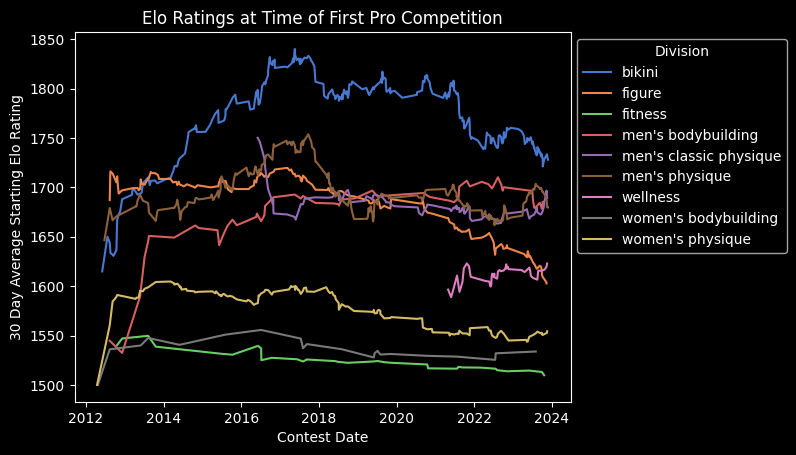

In [22]:
ax = sns.lineplot(
    data=df_starting_elo,
    x="contest_date",
    y="30dayrollavg_starting_elo",
    hue="division",
    palette="muted",
)
plt.xlabel("Contest Date")
plt.ylabel("30 Day Average Starting Elo Rating")
plt.title("Elo Ratings at Time of First Pro Competition")
plt.style.use("dark_background")
plt.legend(title="Division")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [23]:
df_starting_elo[(df_starting_elo["year"] >= 2022)].groupby("division")[
    "elo_rating"
].median()

division
bikini                    1767.322551
figure                    1616.697157
fitness                   1516.321973
men's bodybuilding        1651.343338
men's classic physique    1691.314565
men's physique            1688.990596
wellness                  1605.851590
women's bodybuilding      1570.597079
women's physique          1547.449725
Name: elo_rating, dtype: float64